In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

 99% 1.06G/1.06G [00:07<00:00, 106MB/s]
100% 1.06G/1.06G [00:07<00:00, 159MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [9]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten,Dropout,BatchNormalization
from keras.applications.vgg16 import VGG16

In [5]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [6]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [7]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [10]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_1 (Dense)             (None, 256)               8388864   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)               

In [14]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [12]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [19]:
batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/train',
        target_size=(256,256),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/content/test',
        target_size=(256,256),
        batch_size=batch_size,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [16]:
# Normalize
def process(image,label):
    image = tensorflow.cast(image/255. ,tensorflow.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [20]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
  )

In [21]:
history = model.fit_generator(
        train_generator,
        epochs=15,
        validation_data=validation_generator)

<ipython-input-21-f568010376c1>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/15
625/625 [==============================] - 394s 611ms/step - loss: 0.3018 - accuracy: 0.8635 - val_loss: 0.1238 - val_accuracy: 0.9512
Epoch 2/15
625/625 [==============================] - 370s 592ms/step - loss: 0.1458 - accuracy: 0.9446 - val_loss: 0.0965 - val_accuracy: 0.9612
Epoch 3/15
625/625 [==============================] - 369s 590ms/step - loss: 0.1143 - accuracy: 0.9571 - val_loss: 0.0756 - val_accuracy: 0.9702
Epoch 4/15
625/625 [==============================] - 371s 594ms/step - loss: 0.0971 - accuracy: 0.9655 - val_loss: 0.0696 - val_accuracy: 0.9732
Epoch 5/15
625/625 [==============================] - 378s 605ms/step - loss: 0.0831 - accuracy: 0.9698 - val_loss: 0.0656 - val_accuracy: 0.9734
Epoch 6/15
625/625 [==============================] - 367s 587ms/step - loss: 0.0753 - accuracy: 0.9722 - val_loss: 0.0599 - val_accuracy: 0.9766
Epoch 7/15
625/625 [==============================] - 372s 595ms/step - loss: 0.0644 - accuracy: 0.9772 - val_loss: 0.0657 -

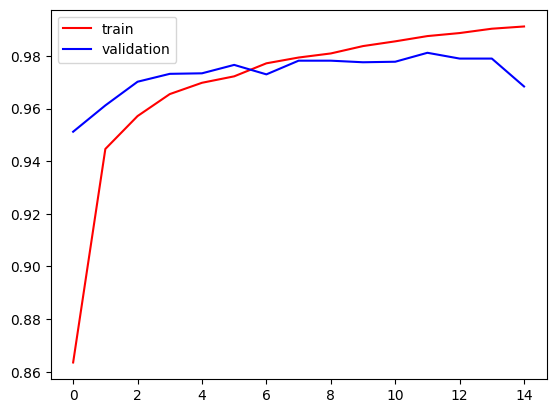

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

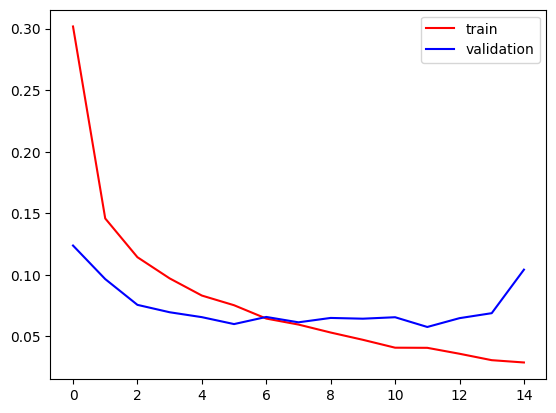

In [23]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [24]:
model.evaluate(validation_generator)

157/157 [==============================] - 28s 180ms/step - loss: 0.1042 - accuracy: 0.9684


[0.10417494177818298, 0.9684000015258789]